# 1. Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix ,precision_score, recall_score, roc_auc_score ,roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
import numpy as np

# 2. Load Data

In [ ]:
drive.mount('/content/drive')


unmon_features= pd.read_csv('/content/drive/MyDrive/MLproject/unmon_features.csv')
mon_features= pd.read_csv('/content/drive/MyDrive/MLproject/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/MLproject/mon_labels.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mon_features['label'] = mon_labels.values
unmon_features['label'] = -1

combined_data = pd.concat([mon_features, unmon_features], axis=0, ignore_index= True)
combined_data.fillna(0, inplace=True)

X = combined_data.drop('label', axis=1)
y = combined_data['label']


print(X.head)

<bound method NDFrame.head of        total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0           1421        -603648   4.315749       1300   4.292023    5579.63   
1            518        -183296   4.611815        438   4.673242    2046.88   
2           1358        -574464   5.488969       1240   5.459452    6769.72   
3           1446        -615424   5.995512       1324   5.948693    7876.07   
4           1406        -602112   4.698869       1291   4.663873    6021.06   
...          ...            ...        ...        ...        ...        ...   
28995       4593       -1928704  12.494690       4180  12.360713   51667.78   
28996       5110       -2158592  13.844609       4663  13.729719   64021.68   
28997        361        -124416   3.568144        302   3.251291     981.89   
28998        509        -162304   6.892377        413   6.689346    2762.70   
28999       9990       -4785152   7.916714       9668   7.923616   76605.52   

       inpkt_num_frac

# 3. Preprocess Data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(23200, 19) (5800, 19)


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision", precision_score(y_test, y_pred, average='macro'))
# print("Recall", recall_score(y_test, y_pred, average='macro'))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6701724137931034

Confusion Matrix:
 [[1788    2    2 ...    0    0    3]
 [   8   17    0 ...    1    0    1]
 [  14    0   12 ...    1    0    0]
 ...
 [  14    0    0 ...   17    0    1]
 [   8    1    0 ...    0   36    0]
 [  10    0    0 ...    0    0   18]]


# 5. Hyperparameter Tuning

In [ ]:
#하이퍼파라미터 튜닝(GridSearch)
param_grid = {
    # 'n_estimators': [500,1000,1500],
    'n_estimators': [300],
    'max_depth': [10, 20, 30,40,50],
    'max_leaf_nodes':[100,200,300],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(estimator = rf_model,param_grid = param_grid, cv = 5,scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)


best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_


print("Best parameters:", best_params)
print("Best Model:\n", best_rf_model)
print("Best Accuracy:", best_accuracy)



Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: 

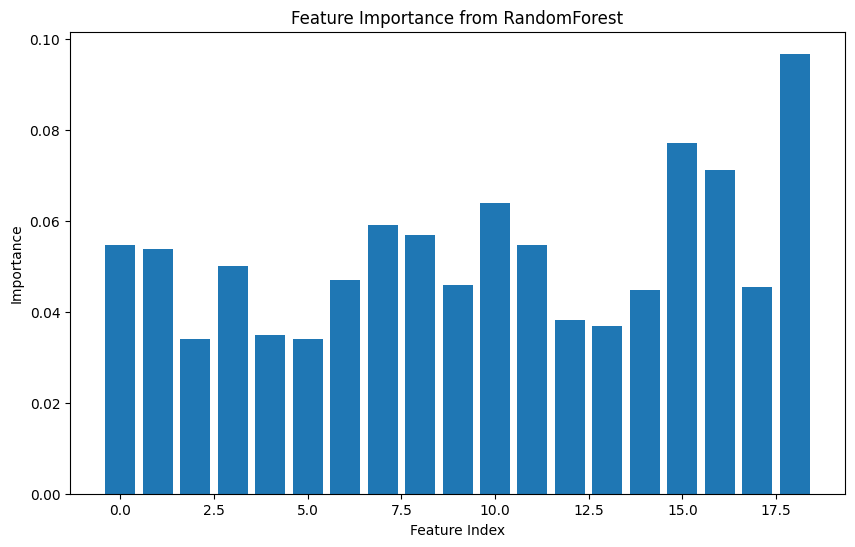

Selected Features Index: [ 0  1  3  6  7  8  9 10 11 14 15 16 17 18]
Number of Important Features: 14

Accuracy (Selected Features): 0.6856896551724138

Confusion Matrix (Selected Features):
 [[1776    1    3 ...    0    1    3]
 [   8   17    0 ...    0    0    0]
 [  16    0   12 ...    0    0    0]
 ...
 [  11    0    0 ...   19    0    1]
 [   4    1    0 ...    0   40    0]
 [   8    0    0 ...    0    0   20]]

Classification Report (Selected Features):
               precision    recall  f1-score   support

          -1       0.66      0.90      0.76      1977
           0       0.77      0.49      0.60        35
           1       0.57      0.32      0.41        38
           2       0.85      0.76      0.80        37
           3       0.67      0.44      0.53        36
           4       0.65      0.76      0.70        34
           5       0.85      0.61      0.71        36
           6       0.77      0.77      0.77        35
           7       0.56      0.57      0.57     

In [ ]:
# 특성 중요도 확인
feature_importances = rf_model.feature_importances_

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance from RandomForest')
plt.show()

# 중요도 기준으로 상위 N개 특성 선택
threshold = 0.04  # 중요도 기준 (조정 가능)
important_features = np.where(feature_importances >= threshold)[0]
print(f"Selected Features Index: {important_features}")
print(f"Number of Important Features: {len(important_features)}")

# 선택된 중요 특성 데이터로 새로운 학습 데이터셋 구성
X_train_selected = X_train_scaled[:, important_features]
X_test_selected = X_test_scaled[:, important_features]

# 새로운 학습 데이터로 RandomForest 학습
rf_model_selected = RandomForestClassifier(random_state=42)
rf_model_selected.fit(X_train_selected, y_train)

# 성능 평가
y_pred_selected = rf_model_selected.predict(X_test_selected)
print("\nAccuracy (Selected Features):", accuracy_score(y_test, y_pred_selected))
print("\nConfusion Matrix (Selected Features):\n", confusion_matrix(y_test, y_pred_selected))
print("\nClassification Report (Selected Features):\n", classification_report(y_test, y_pred_selected))

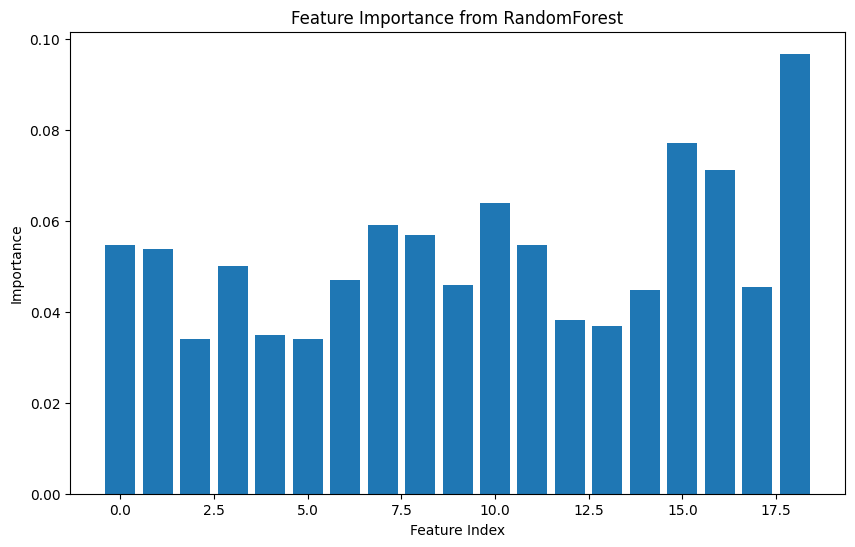

Selected Features Index: [ 0  1  3  7  8 10 11 15 16 18]
Number of Important Features: 10

Accuracy (Selected Features): 0.7068965517241379

Confusion Matrix (Selected Features):
 [[1756    4    5 ...    0    0    5]
 [  12   18    0 ...    0    0    0]
 [  12    0   14 ...    0    0    0]
 ...
 [  14    0    0 ...   20    0    1]
 [   4    0    0 ...    0   39    0]
 [  14    0    0 ...    0    0   18]]

Classification Report (Selected Features):
               precision    recall  f1-score   support

          -1       0.63      0.89      0.74      1977
           0       0.75      0.51      0.61        35
           1       0.67      0.37      0.47        38
           2       0.92      0.89      0.90        37
           3       0.73      0.53      0.61        36
           4       0.63      0.79      0.70        34
           5       0.83      0.81      0.82        36
           6       0.82      0.77      0.79        35
           7       0.65      0.55      0.60        47
      

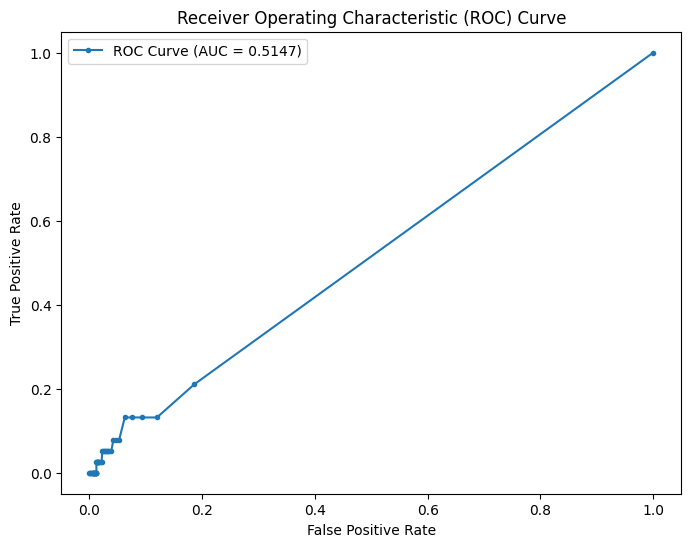

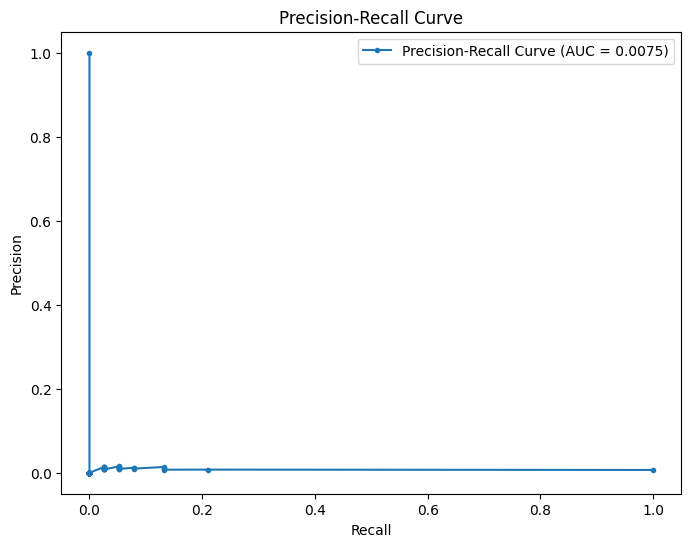

In [ ]:
# # 특성 중요도 확인
# feature_importances = rf_model.feature_importances_

# # 중요도 시각화
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances, align='center')
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.title('Feature Importance from RandomForest')
# plt.show()

# # 중요도 기준으로 상위 N개 특성 선택
# threshold = 0.05  # 중요도 기준 (조정 가능)
# important_features = np.where(feature_importances >= threshold)[0]
# print(f"Selected Features Index: {important_features}")
# print(f"Number of Important Features: {len(important_features)}")

# # 선택된 중요 특성 데이터로 새로운 학습 데이터셋 구성
# X_train_selected = X_train_scaled[:, important_features]
# X_test_selected = X_test_scaled[:, important_features]

# # 새로운 학습 데이터로 RandomForest 학습
# rf_model_selected = RandomForestClassifier(n_estimators = 300, random_state=42, class_weight='balanced')
# rf_model_selected.fit(X_train_selected, y_train)

# 성능 평가
y_pred_selected = rf_model_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
print("\nAccuracy (Selected Features):", accuracy_selected)
print("\nConfusion Matrix (Selected Features):\n", conf_matrix_selected)
print("\nClassification Report (Selected Features):\n", classification_report(y_test, y_pred_selected))

# 확률 예측 (predict_proba 활용)
y_pred_proba_selected = rf_model_selected.predict_proba(X_test_selected)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_selected, pos_label=1)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_proba_selected, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# 최종 성능 출력
print(f"\nAccuracy (Tuned Model): {accuracy_selected:.4f}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_selected}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


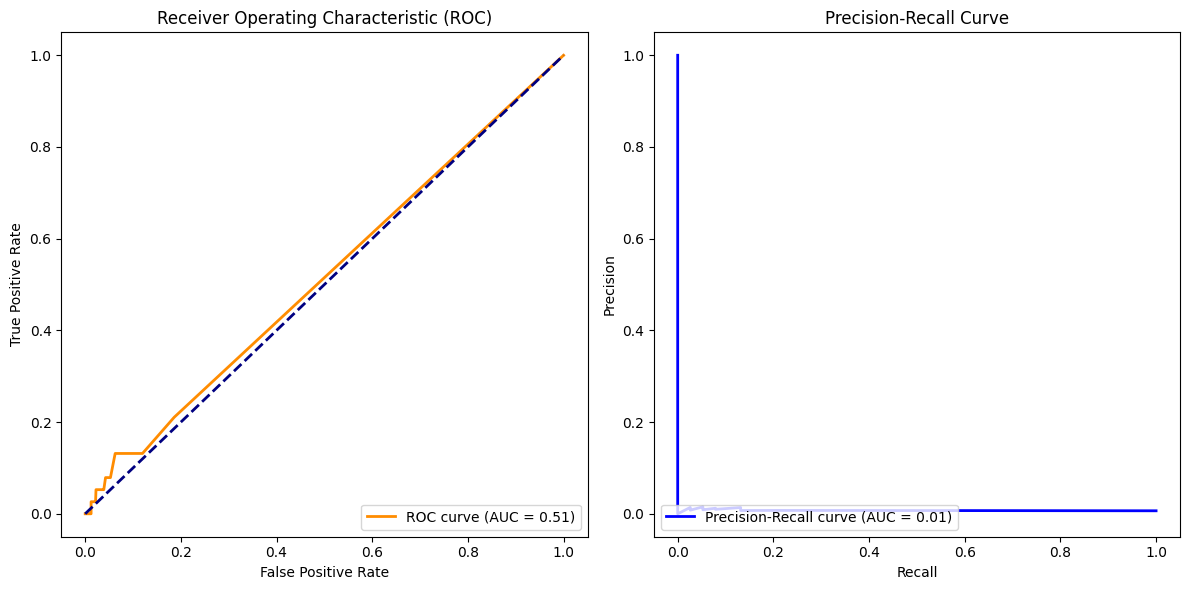

In [ ]:
# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# 6. Evaluate the Tuned Model


In [ ]:
# Predict using the best model from GridSearchCV
y_pred_random = best_rf_model.predict(X_test)

# Evaluate model performance
accuracy_best = accuracy_score(y_test, y_pred_random)
conf_matrix_best = confusion_matrix(y_test, y_pred_random)

# Compute precision and recall for positive class (assuming binary classification)
precision = precision_score(y_test, y_pred_random, average='macro')  # 'macro' for multi-class
recall = recall_score(y_test, y_pred_random, average='macro')  # 'macro' for multi-class

# Calculate ROC and Precision-Recall AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

precision_values, recall_values, _ = precision_recall_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1], pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Print metrics
print(f"Accuracy (Tuned Model): {accuracy_best:.4f}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_best}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

NameError: name 'best_rf_model' is not defined

# 7. Visualize Results

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Visualize Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, marker='.', label=f"Precision-Recall Curve (AUC = {pr_auc:.4f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

NameError: name 'fpr' is not defined

<Figure size 800x600 with 0 Axes>